# Assigment 5

**Submission deadlines**:

* last lab before 27.06.2022 

**Points:** Aim to get 12 out of 15+ possible points

All needed data files are on Drive: <https://drive.google.com/drive/folders/1uufpGn46Mwv4oBwajIeOj4rvAK96iaS-?usp=sharing>

## Setup


In [ ]:
import torch
files = 'data'

In [ ]:
torch.cuda.is_available()

True

## Task 1 (5 points)

Consider the vowel reconstruction task -- i.e. inserting missing vowels (aeuioy) to obtain proper English text. For instance for the input sentence:

<pre>
h m gd smbd hs stln ll m vwls
</pre>

the best result is

<pre>
oh my god somebody has stolen all my vowels
</pre>

In this task both dev and test data come from the two books about Winnie-the-Pooh. You have to train two RNN Language Models on *pooh-train.txt*. For the first model use the code below, for the second choose different hyperparameters (different dropout, smaller number of units or layers, or just do any modification you want). 

The code below is based on
https://www.kdnuggets.com/2020/07/pytorch-lstm-text-generation-tutorial.html

In [ ]:
from collections import Counter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SEQUENCE_LENGTH = 15

class PoohDataset(torch.utils.data.Dataset):
    def __init__(self, sequence_length, device):
        txt = open(f'{files}/pooh_train.txt').read()
        
        self.words = txt.lower().split() # The text is already tokenized
        
        self.uniq_words = self.get_uniq_words()

        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}

        self.words_indexes = [self.word_to_index[w] for w in self.words]
        self.sequence_length = sequence_length
        self.device = device


    def get_uniq_words(self):
        word_counts = Counter(self.words)
        return sorted(word_counts, key=word_counts.get, reverse=True)

    def __len__(self):
        return len(self.words_indexes) - self.sequence_length

    def __getitem__(self, index):
        return (
            torch.tensor(self.words_indexes[index:index+self.sequence_length], device=self.device),
            torch.tensor(self.words_indexes[index+1:index+self.sequence_length+1], device=self.device)
        )
        
pooh_dataset = PoohDataset(SEQUENCE_LENGTH, device)        

In [ ]:
from torch import nn, optim

class LSTMModel(nn.Module):
    def __init__(self, dataset, device=device,
                 lstm_size = 512, 
                 embedding_dim = 100,
                 num_layers = 2,
                 dropout = 0.2):
        super(LSTMModel, self).__init__()
        self.lstm_size = lstm_size
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        self.device = device
        

        n_vocab = len(dataset.uniq_words)
        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
        )
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            dropout=dropout,
        )
        self.fc = nn.Linear(self.lstm_size, n_vocab)
        self.to(device)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)
        return logits, state

    def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.lstm_size).to(self.device),
                torch.zeros(self.num_layers, sequence_length, self.lstm_size).to(self.device))

In [ ]:
import numpy as np
from torch.utils.data import DataLoader

batch_size = 512
max_epochs = 30

def train(dataset, model):
    model.train()

    dataloader = DataLoader(dataset, batch_size=batch_size)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(max_epochs):
        state_h, state_c = model.init_state(SEQUENCE_LENGTH)
        
        for batch, (x, y) in enumerate(dataloader):
            
            optimizer.zero_grad()

            y_pred, (state_h, state_c) = model(x, (state_h, state_c))
            loss = criterion(y_pred.transpose(1, 2), y)

            state_h = state_h.detach()
            state_c = state_c.detach()            

            loss.backward()
            optimizer.step()

        #print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })    

In [ ]:
class Sequence(list):
    def __init__(self, word = None, p = 1):
        if word: self.append(word)
        self.p = p
    def __add__(self, seq):
        new = Sequence(p = self.p * seq.p)
        new.extend(self)
        new.extend(seq)
        return new
    def __lt__(self, seq):
        return self.p < seq.p


class Beam:
    def __init__(self, dataset, model, representations, k = 5):
        self.dataset = dataset
        self.model = model
        self.representations = representations
        self.sequences = []
        self.k = k

    def kbest(self, seqs):
        return sorted(seqs, reverse = True)[:self.k]

    def kpredict(self, seq, candidates):
        self.model.eval()
        idx = self.dataset.word_to_index
        state_h, state_c = self.model.init_state(len(seq))
        x = torch.tensor([[idx[w] for w in seq]]).to(device)
        y_pred, (state_h, state_c) = self.model(x, (state_h, state_c))
        last_word_logits = y_pred[0][-1]

        distribution = torch.nn.functional.softmax(last_word_logits, dim=0).detach().cpu().numpy()
        return [seq + Sequence(w, distribution[idx[w]]) for w in candidates]

    def __call__(self, text):
        text = text.split()
        self.sequences = [Sequence(word) for word in self.representations[text[0]]]
        for typo in text[1:]:
            candidates = self.representations[typo]
            #print(candidates)
            self.sequences = self.kbest([seq for s in self.sequences for seq in self.kpredict(s, candidates)])
        return " ".join(self.kbest(self.sequences)[0])

## Testing

You can assume that only words from pooh_words.txt can occur in the reconstructed text. For decoding you have two options (choose one, or implement both ang get **+1** bonus point)

1. Sample reconstructed text several times (with quite a low temperature), choose the most likely result.
2. Perform beam search.

Of course in the sampling procedure you should consider only words matching the given consonants.

Report accuracy of your methods (for both language models). The accuracy should be computed by the following function, it should be *greater than 0.25*.


```python
def accuracy(original_sequence, reconstructed_sequence):
    sa = original_sequence
    sb = reconstructed_sequence
    score = len([1 for (a,b) in zip(sa, sb) if a == b])
    return score / len(original_sequence)
```

In [ ]:
from collections import defaultdict as dd

class Test:
    def __init__(self, test_set = f'{files}/pooh_train.txt'):
        self.vowels = set("aoiuye'")
        self.words = list(open(test_set).read().split())
        self.representation = dd(set)

        for w in set(self.words):
            r = self.devowelize(w)
            self.representation[r].add(w)
    
    def devowelize(self, s):
        rv = ''.join(a for a in s if a not in self.vowels)
        if rv:
            return rv
        return '_' # Symbol for words without consonants

    def accuracy(self, original_sequence, reconstructed_sequence):
        sa = original_sequence
        sb = reconstructed_sequence
        score = len([1 for (a,b) in zip(sa, sb) if a == b])
        return score / len(original_sequence)

    def __call__(self, model, n = 1000, verbose = False):
        model.eval()
        accuracy = 0
        batch = 10
        beam = Beam(pooh_dataset, model, self.representation, k = 50)
        for i in range(0, n*batch, batch):
            sentence = " ".join(self.words[i:i+batch])
            typos = self.devowelize(sentence)
            reconstruction = beam(typos)
            acc = self.accuracy(sentence, reconstruction)
            accuracy += acc
            if verbose and not (i // batch) % (n // 50):
                print(f'\033[94m{sentence:<70}\033[0m \033[91m{reconstruction:<70}\033[0m {acc}')
        return accuracy / n


In [ ]:
test = Test()

In [ ]:
default = LSTMModel(pooh_dataset)
train(pooh_dataset, default)
test(default)

0.3943136962632499

In [ ]:
"increased droput from 0.2 to 0.5"
drops = LSTMModel(pooh_dataset, dropout = 0.5)
train(pooh_dataset, drops)
test(drops)

0.4330073773373975

In [ ]:
"increased RNN layers from 2 to 4"
layers = LSTMModel(pooh_dataset, num_layers = 4)
train(pooh_dataset, layers)
test(layers)

0.39181968033482706

In [ ]:
"increased size of the word embeddings from 100 to 300"
embedding = LSTMModel(pooh_dataset, embedding_dim = 300)
train(pooh_dataset, embedding)
test(embedding)

0.37979933153858886

In [ ]:
"reduced lstm_size from 512 to 256"
size = LSTMModel(pooh_dataset, lstm_size = 256)
train(pooh_dataset, size)
test(size)

0.4378869975921028

In [ ]:
test(default, verbose = True)

winnie-the-pooh by a . a. milne to her hand in                         winnie-the-pooh by . a. milne to her hand in                           0.43478260869565216
the zoo . there are some people who begin the                          the zoo . either are some people who began they                        0.24444444444444444
as this when piglet looked up and said in his                          us those when piglet liked up and said in house                        0.5555555555555556
`` what about us ? '' so perhaps the best                              `` what about yes ? so perhaps they best                               0.34146341463414637
head , behind christopher robin . it is , as                           ahead , behind christopher robin . at yes , so                         0.022727272727272728
he likes to sit quietly in front of the fire                           ha looks to sit quietly in front if the for                            0.8409090909090909
said a growly voice . `` then

0.3943136962632499

In [ ]:
test(size, verbose = True)

winnie-the-pooh by a . a. milne to her hand in                         winnie-the-pooh by . a. milne to her hand in                           0.43478260869565216
the zoo . there are some people who begin the                          the zoo . there are some people who begin the                          1.0
as this when piglet looked up and said in his                          as these when piglet looked up and used in house                       0.15555555555555556
`` what about us ? '' so perhaps the best                              `` what about so ? as perhaps the best                                 0.4634146341463415
head , behind christopher robin . it is , as                           ahead , behind christopher robin . at so , so                          0.045454545454545456
he likes to sit quietly in front of the fire                           he likes 'it sit quietly in front of the fur                           0.20454545454545456
said a growly voice . `` then i will go     

0.4378869975921028

## Task 2 (6 points)

This task is about text generation. You have to:

**A**. Create text corpora containing texts with similar vocabulary (for instance books from the same genre, or written by the same author). This corpora should have approximately 1M words. You can consider using the following sources: Project Gutenberg (https://www.gutenberg.org/), Wolne Lektury (https://wolnelektury.pl/), parts of BookCorpus, https://github.com/soskek/bookcorpus, but generally feel free. Texts could be in English, Polish or any other language you know.

**B**. choose the tokenization procedure. It should have two stages:

1. word tokenization (you can use nltk.tokenize.word_tokenize, tokenizer from spaCy, pytorch, keras, ...). Test your tokenizer on your corpora, and look at a set of tokens containing both letters and special characters. If some of them should be in your opinion treated as a sequence of tokens, then modify the tokenization procedure

2. sub-word tokenization (you can either use the existing procedure, like wordpiece or sentencepiece, or create something by yourself). Here is a simple idea: take 8K most popular words (W), 1K most popular suffixes (S), and 1K most popular prefixes (P). Words in W are its own tokens. Word x outside W should be tokenized as 'p_ _s' where p is the longest prefix of x in P, and s is the longest prefix of W

**C**. write text generation procedure. The procedure should fulfill the following requirements:

1. it should use the RNN language model (trained on sub-word tokens)
2. generated tokens should be presented as a text containing words (without extra spaces, or other extra characters, as begin-of-word introduced during tokenization)
3. all words in a generated text should belond to the corpora (note that this is not guaranteed by LSTM)
4. in generation Top-P sampling should be used (see NN-NLP.6, slide X) 
5. in generated texts every token 3-gram should be uniq
6. *(optionally, +1 point)* all token bigrams in generated texts occur in the corpora

## Task 3

In this task you have to create a network which looks at characters of the word and tries to guess whether the word is a noun, a verb, an adjective, and so on. To be more precise: the input is a word (without context), the output is a POS-tag (Part-of-Speech). Since some words are unambiguous, and we have no context, our network is supposed to return the set of possible tags.

The data is taken from Universal Dependencies English corpus, and of course it contains errors, especially because not all possible tags occured in the data.

Train a network (4p) or two networks (+2p) solving this task. Both networks should look at character n-grams occuring in the word. There are two options:

* **Fixed size:** for instance take 2,3, and 4-character suffixes of the word, use them as  features (whith 1-hot encoding). You can also combine prefix and suffix features. Simple, useful trick: when looking at suffixes, add some '_' characters at the beginning of the word to guarantee that shorter words have suffixes of a desired length.

* **Variable size:** take for instance 4-grams (or 4 grams and 3-grams), use Deep Averaging Network. Simple trick: add extra character at the beginning and at the end of the word, to add the information, that ngram occurs at special position ('ed' at the end has slightly different meaning that 'ed' in the middle)


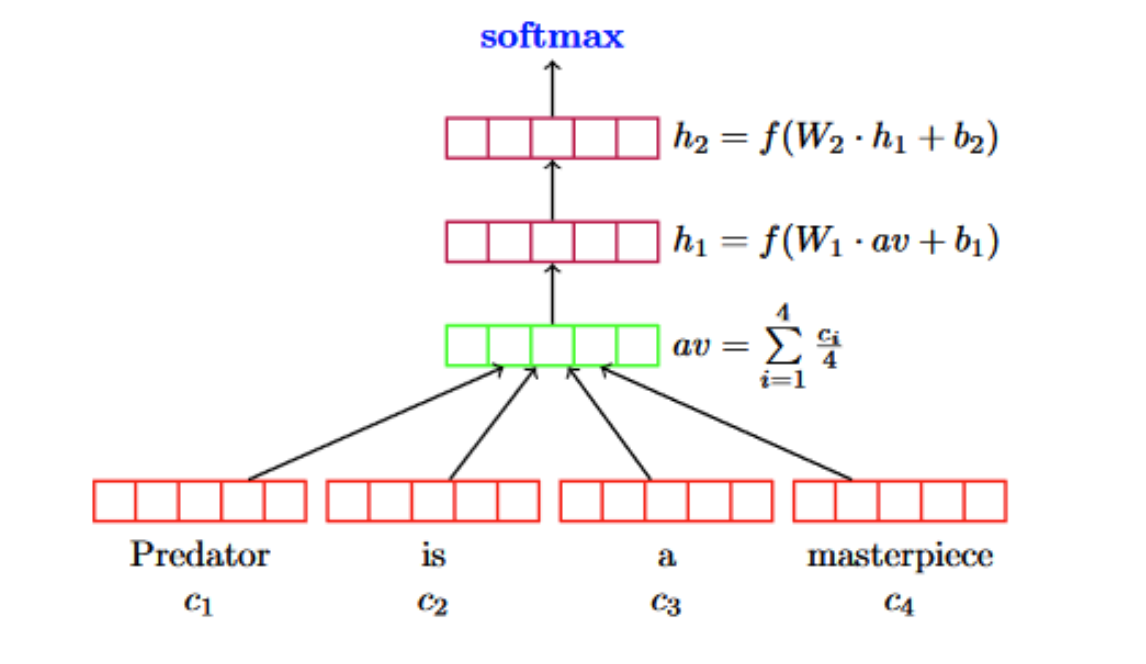

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class DeepAveragingNetwork(nn.Module):

    def __init__(self,
                 n_embed=10000,
                 d_embed=300,
                 d_hidden=256,
                 d_out=2,
                 dp=0.2,
                 embed_weight=None):

        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.embed = nn.Embedding(n_embed, d_embed)

        self.dropout1 = nn.Dropout(dp)
        self.bn1 = nn.BatchNorm1d(d_embed)
        self.fc1 = nn.Linear(d_embed, d_hidden)
        self.dropout2 = nn.Dropout(dp)
        self.bn2 = nn.BatchNorm1d(d_hidden)
        self.fc2 = nn.Linear(d_hidden, d_out)

    def forward(self, batch):
        text = batch.text
        label = batch.label

        x = self.embed(text)

        x = x.mean(dim=0)

        x = self.dropout1(x)
        x = self.bn1(x)
        x = self.fc1(x)
        x = self.dropout2(x)
        x = self.bn2(x)
        x = self.fc2(x)

        return x

In [ ]:
dan = DeepAveragingNetwork()

In [ ]:
import numpy as np
from torch.utils.data import DataLoader

batch_size = 512
max_epochs = 30

def train(dataset, model):
    model.train()

    dataloader = DataLoader(dataset, batch_size=batch_size)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(max_epochs):
        state_h, state_c = model.init_state(SEQUENCE_LENGTH)
        
        for batch, (x, y) in enumerate(dataloader):
            
            optimizer.zero_grad()

            y_pred, (state_h, state_c) = model(x, (state_h, state_c))
            loss = criterion(y_pred.transpose(1, 2), y)

            state_h = state_h.detach()
            state_c = state_c.detach()            

            loss.backward()
            optimizer.step()

        print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })    

## Task 4

Apply seq2seq model (you can modify the code from this tutorial: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) to compute grapheme to phoneme conversion for English. Train the model on dev_cmu_dict.txt and test it on test_cmu_dict.txt. Report accuracy of your solution using two metrics:
* exact match (how many words are perfectly converted to phonemes)
* exact match without stress (how many words are perfectly converted to phonemes when we remove the information about stress)
